# Import Dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [173]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import extract
from sqlalchemy import and_
from sqlalchemy import or_
from mpl_toolkits.basemap import Basemap

In [174]:
from flask import jsonify

# Reflect Tables into SQLAlchemy ORM

In [5]:
engine = create_engine("sqlite:////Users/cla/Desktop/UM Data Science/Homework/10 -sqlalchemy-challenge/Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
last_date=session.query(Measurement.date).\
order_by(Measurement.date.desc()).first()

for date in last_date:
    split_last_date=date.split('-')
    
last_year=int(split_last_date[0]); last_month=int(split_last_date[1]); last_day=int(split_last_date[2])

query_date = dt.date(last_year, last_month, last_day) - dt.timedelta(days=365)

print(query_date)

2016-08-23


# Precipitation Analysis 

In [178]:
last_year = session.query(Measurement.date,Measurement.station,Measurement.prcp).\
filter(Measurement.date>=query_date).\
order_by(Measurement.date).all()

last_year

last_year_df = pd.DataFrame(last_year).set_index('date').dropna()


In [179]:
last_year_df.head()


,station,prcp
date,,
2016-08-23,USC00519397,0.00
2016-08-23,USC00513117,0.15
2016-08-23,USC00514830,0.05
2016-08-23,USC00519523,0.02
2016-08-23,USC00519281,1.79


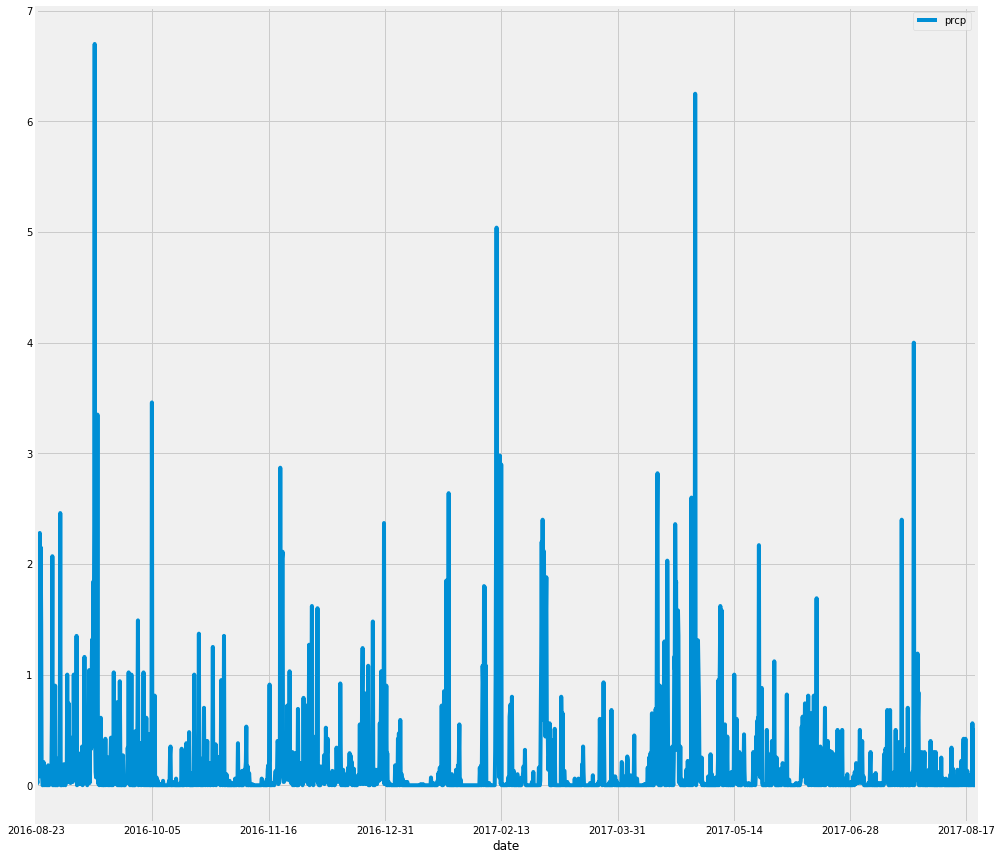

In [13]:
last_year_df.plot(figsize=(15,15))
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_stats = last_year_df.describe()

prcp_stats



,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [15]:
#Stations available in dataset

station_count = session.query(Measurement.station).\
group_by(Measurement.station).count()

station_count


9

In [16]:
# The most active stations
station_activity = session.query(func.count(Measurement.station).label('count'), Measurement.station).\
group_by(Measurement.station).\
order_by('count').all()

station_activity_df = pd.DataFrame(station_activity).dropna()

station_activity_df = station_activity_df.sort_values(by='count', ascending=False)

station_activity_df

,count,station
8,2772,USC00519281
7,2724,USC00519397
6,2709,USC00513117
5,2669,USC00519523
4,2612,USC00516128
3,2202,USC00514830
2,1979,USC00511918
1,1372,USC00517948
0,511,USC00518838


In [141]:
station_names = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_names = pd.DataFrame(station_names)
station_names

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [18]:
most_active = station_activity_df.head(1)
most_active_station = most_active['station'].values[0]
print('The most active station is: ' + str(most_active_station))

The most active station is: USC00519281


In [19]:
least_active = station_activity_df.sort_values(by='count').head(1)
least_active_station = least_active['station'].values[0]
print('The least active station is: ' + str(least_active_station))

The least active station is: USC00518838


In [20]:
# The lowest temperature recorded

station_temperature = session.query(func.min(Measurement.tobs).label('min_temp'), Measurement.station).\
group_by(Measurement.station).\
order_by('min_temp').all()

station_mintemp_df = pd.DataFrame(station_temperature).dropna()

station_mintemp_df = station_mintemp_df.sort_values(by='min_temp')

min_temp_recorded = station_mintemp_df['min_temp'].values[0]
min_temp_station = station_mintemp_df['station'].values[0]
print('The minimum temperature recorded is ' + str(min_temp_recorded) + ' in station ' + str(min_temp_station))

station_mintemp_df


The minimum temperature recorded is 53.0 in station USC00511918


,min_temp,station
0,53.0,USC00511918
1,54.0,USC00519281
2,56.0,USC00519397
3,56.0,USC00519523
4,58.0,USC00514830
5,58.0,USC00516128
6,58.0,USC00517948
7,58.0,USC00518838
8,59.0,USC00513117


In [21]:
#Lowest and highest temperature recorded, and average temperature of the most active station

most_active_summary = session.query(func.count(Measurement.station).label('count'), Measurement.station,\
(func.max(Measurement.tobs)), (func.min(Measurement.tobs)), (func.avg(Measurement.tobs))).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()

most_active_summary

(2772, 'USC00519281', 85.0, 54.0, 71.66378066378067)

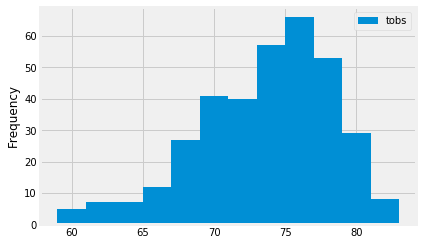

In [22]:
#Temperatures recorded at the most active station in the last year
most_active_station

most_active_ly = session.query(Measurement.date,Measurement.tobs).\
filter(Measurement.date>=query_date).\
filter(Measurement.station==most_active_station).\
order_by(Measurement.date).all()

most_active_ly_df = pd.DataFrame(most_active_ly)
most_active_ly_df.plot.hist(bins=12)
plt.show()

In [148]:
#Date weather calculator (search for weather in historical data)

start_date = input(f'Enter a date to search the weather(yyyy-mm-dd)')
end_date = input(f'End date of your search(yyyy-mm-dd)') 



def calc_temps(start_date, end_date):
    
    trip_temps = session.query(Measurement.date,func.avg(Measurement.tobs),func.max(Measurement.tobs),func.min(Measurement.tobs)).\
    group_by(Measurement.date).\
    filter(Measurement.date>=start_date, Measurement.date <= end_date).all()
    
    return(trip_temps)
calc_temps(start_date, end_date)

Enter a date to search the weather(yyyy-mm-dd)2010-05-20
End date of your search(yyyy-mm-dd)2011-05-20


[('2010-05-20', 72.57142857142857, 77.0, 71.0),
 ('2010-05-21', 73.22222222222223, 77.0, 70.0),
 ('2010-05-22', 75.875, 80.0, 72.0),
 ('2010-05-23', 73.0, 75.0, 70.0),
 ('2010-05-24', 73.375, 77.0, 71.0),
 ('2010-05-25', 73.77777777777777, 77.0, 71.0),
 ('2010-05-26', 74.22222222222223, 78.0, 71.0),
 ('2010-05-27', 73.625, 80.0, 67.0),
 ('2010-05-28', 72.42857142857143, 77.0, 67.0),
 ('2010-05-29', 75.6, 78.0, 74.0),
 ('2010-05-30', 75.16666666666667, 77.0, 73.0),
 ('2010-05-31', 77.42857142857143, 81.0, 75.0),
 ('2010-06-01', 73.55555555555556, 78.0, 69.0),
 ('2010-06-02', 74.55555555555556, 78.0, 70.0),
 ('2010-06-03', 74.44444444444444, 78.0, 67.0),
 ('2010-06-04', 72.88888888888889, 76.0, 68.0),
 ('2010-06-05', 76.0, 79.0, 72.0),
 ('2010-06-06', 76.0, 79.0, 73.0),
 ('2010-06-07', 74.25, 77.0, 69.0),
 ('2010-06-08', 75.625, 79.0, 71.0),
 ('2010-06-09', 75.88888888888889, 80.0, 72.0),
 ('2010-06-10', 75.75, 79.0, 72.0),
 ('2010-06-11', 78.0, 83.0, 75.0),
 ('2010-06-12', 75.0, 78.0, 7

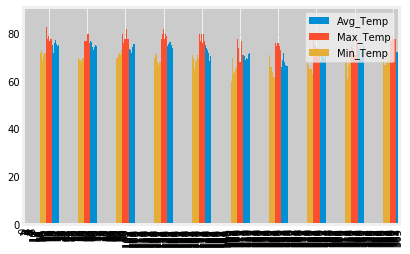

In [149]:
x = calc_temps(start_date, end_date)

trip_temp_df = pd.DataFrame(x, columns=['Date','Avg_Temp','Max_Temp','Min_Temp'])

trip_temp_df.plot.bar()
plt.show()

# Weather forecast calculator for your future trip

In [160]:
#Enter your planned trip datess
dates = []
start_date = input(f'Start date of your trip(yyyy-mm-dd)')
end_date = input(f'End date of your trip(yyyy-mm-dd)') 

for date in start_date, end_date:
    split_date=date.split('-')
    dates.append(split_date)
    
start,end = dates

start_year=(start[0]); start_month=(start[1]); start_day=(start[2])
end_year=(end[0]); end_month=(end[1]); end_day=(end[2])

Start date of your trip(yyyy-mm-dd)2020-02-25
End date of your trip(yyyy-mm-dd)2020-03-10


'10'

In [161]:
#Trip weather calculator

trip = session.query(Measurement.date,func.avg(Measurement.tobs),\
func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.prcp)).\
filter(or_(and_(extract('day', Measurement.date)>=start_day,extract('month', Measurement.date)==start_month),\
(and_(extract('day', Measurement.date)<=end_day,extract('month', Measurement.date)==end_month)))).\
group_by(Measurement.date).all()


trip_forecast_df = pd.DataFrame(trip, columns=['Date','Avg_Temp','Avg_Max_Temp','Avg_Min_Temp','Avg_Precipitation'])
trip_forecast_df.head(5)

,Date,Avg_Temp,Avg_Max_Temp,Avg_Min_Temp,Avg_Precipitation
0,2010-02-25,69.571429,76.0,64.0,0.002857
1,2010-02-26,72.833333,75.0,71.0,0.003333
2,2010-02-27,71.500000,75.0,68.0,0.007500
3,2010-02-28,68.000000,70.0,66.0,0.102000
4,2010-03-01,68.125000,70.0,66.0,0.028571


In [162]:
#Forecast for planned trip

print(f'During your planned trip: From ' + (start_date)  + ' to: ' + (end_date) + ' the weather forecast is the following: ')
print(trip_avgforecast_df.mean())

During your planned trip: From 2020-02-25 to: 2020-03-10 the weather forecast is the following: 
Avg_Temp             68.613104
Avg_Max_Temp         72.919118
Avg_Min_Temp         64.419118
Avg_Precipitation     0.150122
dtype: float64


In [166]:
trip_forecast_summary

Avg_Temp             68.613104
Avg_Max_Temp         72.919118
Avg_Min_Temp         64.419118
Avg_Precipitation     0.150122
dtype: float64

<BarContainer object of 1 artists>

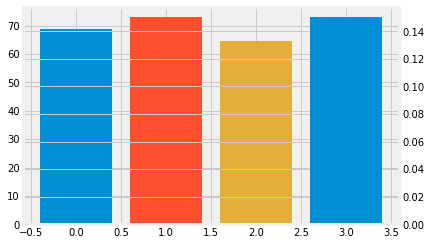

In [172]:
fig,ax=plt.subplots()
for i in range(3):
    ax.bar(x=i,height=trip_forecast_summary[i])
ax2=ax.twinx()
ax2.bar(x=3,height=trip_forecast_summary[3])

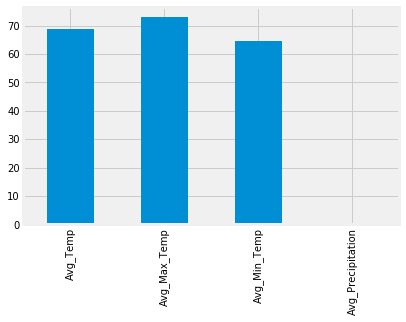

In [163]:
trip_forecast_summary = trip_avgforecast_df.mean()
trip_forecast_summary.plot.bar()

In [147]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
trip_rain = session.query(Measurement.station,func.avg(Measurement.prcp)).\
filter(or_(and_(extract('day', Measurement.date)>=start_day,extract('month', Measurement.date)==start_month),\
(and_(extract('day', Measurement.date)<=end_day,extract('month', Measurement.date)==end_month)))).\
group_by(Measurement.station).all()

trip_rain = pd.DataFrame(trip_rain, columns=['Station','Avg_Precipitation'])

trip_rain

trip_rain_df = trip_rain.merge(station_names, left_on='Station', right_on='station')
del trip_rain_df['station']
trip_rain_df = trip_rain_df.set_index('Station')

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_rain_df.sort_values(by=['Avg_Precipitation'], ascending=False)

,Avg_Precipitation,name,latitude,longitude,elevation
Station,,,,,
USC00516128,0.231333,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
USC00519281,0.217279,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
USC00519523,0.176694,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
USC00513117,0.149118,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
USC00518838,0.123333,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
USC00517948,0.100000,"PEARL CITY, HI US",21.39340,-157.97510,11.9
USC00514830,0.088182,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
USC00511918,0.084062,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
USC00519397,0.077154,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


## Optional Challenge Assignment

In [175]:
# Daily normals 

date_normal = input(f'Insert a month and a day to check historic weather behaviour(mm-dd)')

def daily_normals(date_normal):
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date_normal).all()
    
daily_normals(date_normal)

Insert a month and a day to check historic weather behaviour(mm-dd)12-30


[(63.0, 69.86363636363636, 76.0)]

# Flask app

In [ ]:
@app.route('/_trip_dates')
def trip_dates():
    return jsonify()